In [1]:
import requests
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm


In [2]:
def scan_parquet(slug: str) -> pl.LazyFrame:
    response = requests.get(f"https://osf.io/{slug}/download", stream=True)

    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(f"/tmp/{slug}", "wb") as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

    return pl.scan_parquet(f"/tmp/{slug}")


In [3]:
if "CI" not in os.environ:
    df1 = scan_parquet(
        "musp8",
    ).with_columns(
        pl.lit("baseline").alias("what"),
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).collect()
    len(df1)


In [4]:
if "CI" not in os.environ:
    df2 = scan_parquet(
        "72d6m",
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).with_columns(
        pl.lit("insertions").alias("what"),
    ).collect()
    len(df2)


In [5]:
if "CI" not in os.environ:
    df3 = scan_parquet(
        "sudfh",
    ).filter(
        pl.col("Treatment") == "Slip-duplicate",
    ).with_columns(
        pl.lit("deletions").alias("what"),
    ).collect()
    len(df3)


In [6]:
if "CI" not in os.environ:
    df = pl.concat(
        [df1.lazy(), df2.lazy(), df3.lazy()],
        how="vertical_relaxed",
    ).collect()


In [7]:
if "CI" not in os.environ:
    df = df.with_columns(
        Components=pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ),
    )


In [8]:
if "CI" not in os.environ:
    df = df.with_columns(
        (
            pl.col("Components")
            * pl.col("Has Task")
        ).max().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("max components"),
    )


In [9]:
if "CI" not in os.environ:
    df = df.with_columns(
        TaskNumber=pl.col("Task").replace_strict(
            dict(map(reversed, enumerate(df["Task"].unique()))),
        ),
    ).with_columns(
        TaskBit=np.left_shift(1, pl.col("TaskNumber")),
    )


In [10]:
if "CI" not in os.environ:
    df = df.with_columns(
        SetTaskBit=pl.col("TaskBit") * pl.col("Has Task"),
    )


In [11]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SetTaskBit").bitwise_or().over(
            ["Treatment", "Run ID", "Generation Born", "what"],
        )
        .alias("SetTaskBits"),
    )


In [12]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site").any().over(
            ["Treatment", "Run ID", "Generation Born", "Site", "what"],
        )
        .alias("is any coding site"),
    )


In [13]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Has Task").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site", "what"],
        )
        .alias("num tasks has"),
    )


In [14]:
if "CI" not in os.environ:
    assert df.lazy().group_by(
        ["Treatment", "Run ID", "Generation Born", "what"]
    ).agg(
        pl.col("num tasks has").n_unique(),
    ).select("num tasks has").max().collect().item() == 1


In [15]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("is any coding site").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task", "what"],
        ).alias("num coding sites"),
    )


In [16]:
if "CI" not in os.environ:
    dfx = df.group_by(
        ["Treatment", "Run ID", "Generation Born", "what"],
    ).first()
else:
    dfx = scan_parquet("8xt2p").collect()
dfx.columns


  0%|          | 0.00/219k [00:00<?, ?B/s]

100%|██████████| 219k/219k [00:00<00:00, 6.87MB/s]

['Treatment',
 'Run ID',
 'Generation Born',
 'what',
 'Task',
 'Genome Length',
 'Lineage Generation Index',
 'Is Task Coding Site',
 'Is Viability Site',
 'Site',
 'Update Analyzed',
 'Has Task',
 'Update Born',
 'Components',
 'max components',
 'TaskNumber',
 'TaskBit',
 'SetTaskBit',
 'SetTaskBits',
 'is any coding site',
 'num tasks has',
 'num coding sites']

In [17]:
dfx.write_parquet("/tmp/indel-effect-nulldist.pqt")


In [18]:
df1_ = dfx.filter(pl.col("what") == "baseline").sort(
    "Treatment", "Run ID", "Generation Born"
)
df2_ = dfx.filter(pl.col("what") == "insertions").sort(
    "Treatment", "Run ID", "Generation Born"
)
df3_ = dfx.filter(pl.col("what") == "deletions").sort(
    "Treatment", "Run ID", "Generation Born"
)


In [19]:
delta_ncs_insertion = (
    df2_["num coding sites"].to_numpy().astype(np.int64)
    - df1_["num coding sites"].to_numpy().astype(np.int64)
)


In [20]:
delta_ncs_deletion = (
    df3_["num coding sites"].to_numpy().astype(np.int64)
    - df1_["num coding sites"].to_numpy().astype(np.int64)
)


In [21]:
delta_nth_insertion = (
    df2_["num tasks has"].to_numpy().astype(np.int64)
    - df1_["num tasks has"].to_numpy().astype(np.int64)
)


In [22]:
delta_nth_deletion = (
    df3_["num tasks has"].to_numpy().astype(np.int64)
    - df1_["num tasks has"].to_numpy().astype(np.int64)
)


In [23]:
delta_tasks_insertion = (
    df2_["SetTaskBits"].to_numpy().astype(np.int64)
    != df1_["SetTaskBits"].to_numpy().astype(np.int64)
)


In [24]:
delta_tasks_deletion = (
    df3_["SetTaskBits"].to_numpy().astype(np.int64)
    != df1_["SetTaskBits"].to_numpy().astype(np.int64)
)


In [25]:
gained_task_insertion = (
    df2_["SetTaskBits"].to_numpy().astype(np.int64)
    & np.invert(df1_["SetTaskBits"].to_numpy().astype(np.int64))
).astype(bool)


In [26]:
gained_task_deletion = (
    df3_["SetTaskBits"].to_numpy().astype(np.int64)
    & np.invert(df1_["SetTaskBits"].to_numpy().astype(np.int64))
).astype(bool)


In [27]:
lost_task_insertion = (
    np.invert(df2_["SetTaskBits"].to_numpy().astype(np.int64))
    & df1_["SetTaskBits"].to_numpy().astype(np.int64)
).astype(bool)


In [28]:
lost_task_deletion = (
    np.invert(df3_["SetTaskBits"].to_numpy().astype(np.int64))
    & df1_["SetTaskBits"].to_numpy().astype(np.int64)
).astype(bool)


In [29]:
fitness_effect_lookup = {
    -1: "deleterious",
    0: "neutral",
    1: "beneficial",
}


In [30]:
fitness_effect_insertion = np.vectorize(fitness_effect_lookup.__getitem__)(
    np.sign(2 * gained_task_insertion - lost_task_insertion),
)


In [31]:
fitness_effect_deletion = np.vectorize(fitness_effect_lookup.__getitem__)(
    np.sign(2 * gained_task_insertion - lost_task_insertion),
)


In [32]:
dfz = pl.concat(
    [
        pl.DataFrame(
            {
                "Treatment": df1_["Treatment"],
                "Run ID": df1_["Run ID"],
                "Generation Born": df1_["Generation Born"],
                "what": "insertion",
                "delta num coding sites": delta_ncs_insertion,
                "delta num tasks has": delta_nth_insertion,
                "num tasks has": df1_["num tasks has"],
                "num coding sites": df1_["num coding sites"],
                "delta tasks": delta_tasks_insertion,
                "gained task": gained_task_insertion,
                "lost task": gained_task_insertion,
                "max components": df1_["max components"],
                "fitness effect": fitness_effect_insertion,
            },
        ),
        # disable deletion outputs, as they are not of interest
        # pl.DataFrame(
        #     {
        #         "Treatment": df1_["Treatment"],
        #         "Run ID": df1_["Run ID"],
        #         "Generation Born": df1_["Generation Born"],
        #         "what": "deletion",
        #         "delta num coding sites": delta_ncs_deletion,
        #         "delta num tasks has": delta_nth_deletion,
        #         "num tasks has": df1_["num tasks has"],
        #         "num coding sites": df1_["num coding sites"],
        #         "delta tasks": delta_tasks_deletion,
        #         "gained task": gained_task_deletion,
        #         "lost task": lost_task_deletion,
        #         "max components": df1_["max components"],
        #         "fitness effect": fitness_effect_deletion,
        #     },
        # ),
    ],
)

dfz = dfz.with_columns(
    (
        dfz["delta num coding sites"] / (
            dfz["num coding sites"]
        )
    ).alias("delta frac coding sites")
)
dfz


Treatment,Run ID,Generation Born,what,delta num coding sites,delta num tasks has,num tasks has,num coding sites,delta tasks,gained task,lost task,max components,fitness effect,delta frac coding sites
str,str,i64,str,i64,i64,u32,u32,bool,bool,bool,i64,str,f64
"""Slip-duplicate""","""run_1590""",0,"""insertion""",0,0,0,0,false,false,false,0,"""neutral""",NaN
"""Slip-duplicate""","""run_1590""",12,"""insertion""",0,0,0,0,false,false,false,0,"""neutral""",NaN
"""Slip-duplicate""","""run_1590""",18,"""insertion""",0,0,0,0,false,false,false,0,"""neutral""",NaN
"""Slip-duplicate""","""run_1590""",28,"""insertion""",0,0,0,0,false,false,false,0,"""neutral""",NaN
"""Slip-duplicate""","""run_1590""",34,"""insertion""",0,0,0,0,false,false,false,0,"""neutral""",NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Slip-duplicate""","""run_1619""",1674,"""insertion""",-5,-1,9,82,true,false,false,5,"""deleterious""",-0.060976
"""Slip-duplicate""","""run_1619""",1680,"""insertion""",-79,-9,9,83,true,false,false,5,"""deleterious""",-0.951807
"""Slip-duplicate""","""run_1619""",1685,"""insertion""",-79,-9,9,83,true,false,false,5,"""deleterious""",-0.951807


In [33]:
dfz.to_pandas()


,Treatment,Run ID,Generation Born,what,delta num coding sites,delta num tasks has,num tasks has,num coding sites,delta tasks,gained task,lost task,max components,fitness effect,delta frac coding sites
0,Slip-duplicate,run_1590,0,insertion,0,0,0,0,False,False,False,0,neutral,NaN
1,Slip-duplicate,run_1590,12,insertion,0,0,0,0,False,False,False,0,neutral,NaN
2,Slip-duplicate,run_1590,18,insertion,0,0,0,0,False,False,False,0,neutral,NaN
3,Slip-duplicate,run_1590,28,insertion,0,0,0,0,False,False,False,0,neutral,NaN
4,Slip-duplicate,run_1590,34,insertion,0,0,0,0,False,False,False,0,neutral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,Slip-duplicate,run_1619,1674,insertion,-5,-1,9,82,True,False,False,5,deleterious,-0.060976
7399,Slip-duplicate,run_1619,1680,insertion,-79,-9,9,83,True,False,False,5,deleterious,-0.951807
7400,Slip-duplicate,run_1619,1685,insertion,-79,-9,9,83,True,False,False,5,deleterious,-0.951807
7401,Slip-duplicate,run_1619,1686,insertion,-83,-9,9,83,True,False,False,5,deleterious,-1.000000


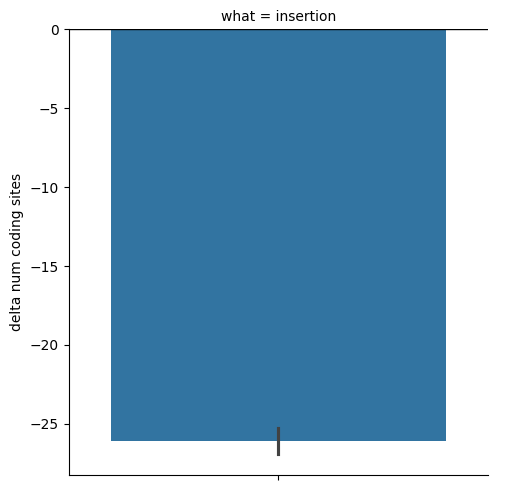

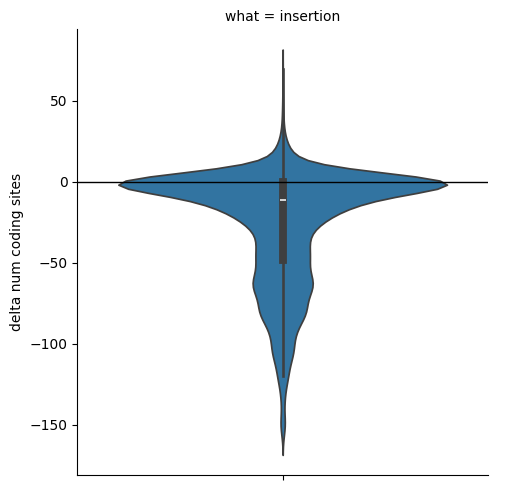

In [34]:
for kind in "bar", "violin":
    saveit, g = tp.tee(
        sns.catplot,
        data=dfz.to_pandas(),
        col="what",
        y="delta num coding sites",
        kind=kind,
        teeplot_callback=True,
    )
    for ax in g.axes.flat:
        ax.axhline(0, color="black", linewidth=1)


(np.float64(-7.295473773265651), np.float64(-6.449280879864637))
(np.float64(1.305241935483871), np.float64(7.806854838709677))
(np.float64(-52.84076154806492), np.float64(-50.22645131086143))
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


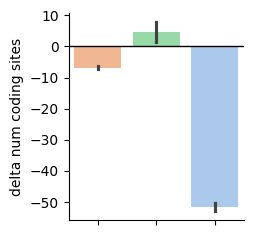

(np.float64(-27.0), np.float64(16.0))
(np.float64(-11.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-16.0), np.float64(28.0))
(np.float64(0.25), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-157.0), np.float64(58.0))
(np.float64(-78.0), np.float64(-17.0))
(np.float64(-53.0), np.float64(-53.0))
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


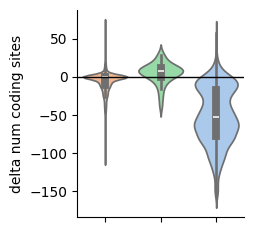

(np.float64(-7.275580130529368), np.float64(-6.4194766739182985))
(np.float64(0.9830645161290323), np.float64(8.178225806451612))
(np.float64(-52.752091136079905), np.float64(-50.179962546816476))
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=bar+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


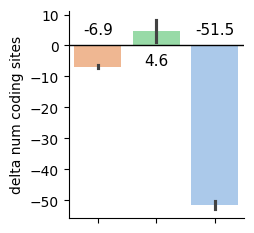

(np.float64(-27.0), np.float64(16.0))
(np.float64(-11.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-16.0), np.float64(28.0))
(np.float64(0.25), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-157.0), np.float64(58.0))
(np.float64(-78.0), np.float64(-17.0))
(np.float64(-53.0), np.float64(-53.0))
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=violin+palette=pastel+textlabels=True+viz=catplot+x=fitness-effect+y=delta-num-coding-sites+ext=.png


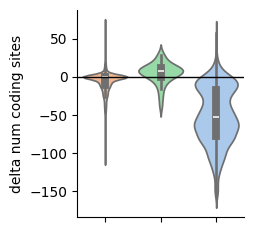

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=probability+viz=displot+x=fitness-effect+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=probability+viz=displot+x=fitness-effect+ext=.png


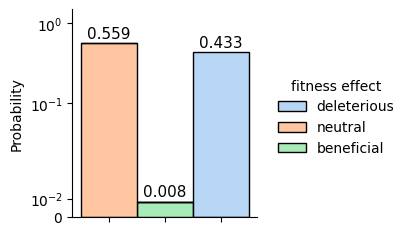

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=count+viz=displot+x=fitness-effect+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=stack+palette=pastel+stat=count+viz=displot+x=fitness-effect+ext=.png


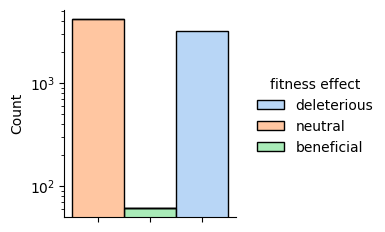

(np.float64(0.031413612565445025), np.float64(0.12827225130890052))
(np.float64(-8.147303921568627), np.float64(-6.175735294117648))
(np.float64(-0.10674157303370786), np.float64(1.2696629213483146))
(np.float64(5.555555555555555), np.float64(9.222222222222221))
(np.float64(-15.989795918367347), np.float64(-12.224234693877552))
(np.float64(-3.908296943231441), np.float64(-2.1526200873362447))
(np.float64(4.179545454545455), np.float64(14.272727272727273))
(np.float64(-24.978932584269664), np.float64(-18.325))
(np.float64(-5.323546511627907), np.float64(-3.4672674418604656))
(np.float64(-6.871739130434783), np.float64(6.264130434782606))
(np.float64(-49.48813645621181), np.float64(-46.54957569585879))
(np.float64(-9.932909836065575), np.float64(-8.536844262295082))
(np.float64(-0.9455882352941174), np.float64(12.588235294117647))
(np.float64(-67.6380081300813), np.float64(-63.202439024390245))
(np.float64(-9.400827205882353), np.float64(-7.315762867647059))
(np.float64(0.0), np.float64(

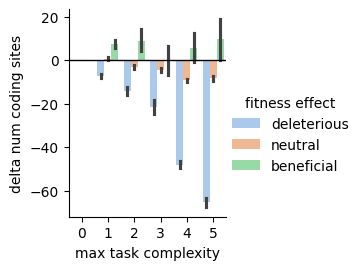

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(12.0))
(np.float64(6.0), np.float64(9.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-32.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.25))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-12.0), np.float64(7.0))
(np.float64(-5.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(21.0))
(np.float64(3.0), np.float64(12.5))
(np.float64(6.0), np.float64(6.0))
(np.float64(-73.0), np.float64(36.0))
(np.float64(-37.0), np.float64(-4.0))
(np.float64(-17.5), np.float64(-17.5))
(np.float64(-22.0), np.float64(13.0))
(np.float64(-9.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-26.

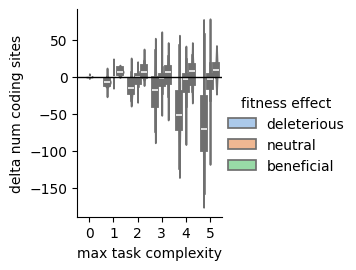

(np.float64(0.031413612565445025), np.float64(0.1256544502617801))
(np.float64(-8.127696078431372), np.float64(-6.185784313725491))
(np.float64(-0.12359550561797752), np.float64(1.2304775280898874))
(np.float64(5.666666666666667), np.float64(9.333333333333334))
(np.float64(-15.877806122448979), np.float64(-12.203826530612245))
(np.float64(-3.8995633187772927), np.float64(-2.1221615720524016))
(np.float64(4.543181818181819), np.float64(14.090909090909092))
(np.float64(-24.938342696629213), np.float64(-18.516432584269662))
(np.float64(-5.4281976744186045), np.float64(-3.425406976744186))
(np.float64(-7.177173913043478), np.float64(6.695652173913044))
(np.float64(-49.483401221995926), np.float64(-46.54355057705364))
(np.float64(-9.964508196721312), np.float64(-8.515191256830601))
(np.float64(-1.0014705882352941), np.float64(12.767647058823528))
(np.float64(-67.54371766444937), np.float64(-63.27307834441981))
(np.float64(-9.36626838235294), np.float64(-7.290854779411765))
(np.float64(0.0),

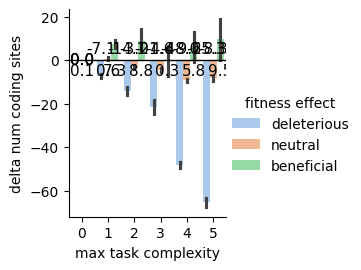

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(12.0))
(np.float64(6.0), np.float64(9.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-32.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.25))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-12.0), np.float64(7.0))
(np.float64(-5.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(21.0))
(np.float64(3.0), np.float64(12.5))
(np.float64(6.0), np.float64(6.0))
(np.float64(-73.0), np.float64(36.0))
(np.float64(-37.0), np.float64(-4.0))
(np.float64(-17.5), np.float64(-17.5))
(np.float64(-22.0), np.float64(13.0))
(np.float64(-9.0), np.float64(0.0))
(np.float64(-1.0), np.float64(-1.0))
(np.float64(-26.

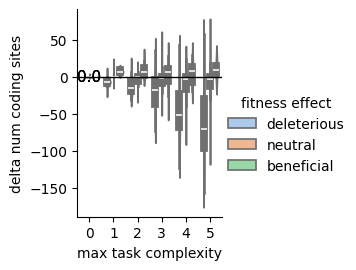

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=max-components+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=max-components+ext=.png


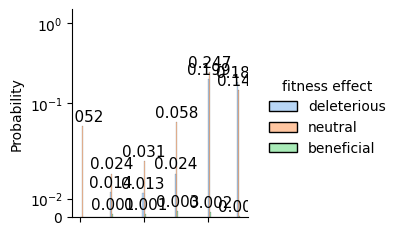

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=max-components+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=max-components+ext=.png


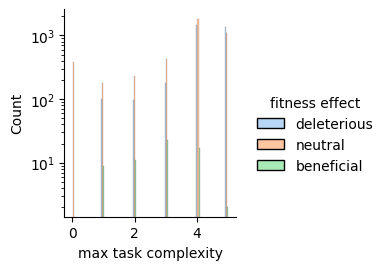

(np.float64(0.031413612565445025), np.float64(0.12827225130890052))
(np.float64(6.0), np.float64(9.75))
(np.float64(-7.337209302325581), np.float64(-5.872093023255814))
(np.float64(-0.27450980392156865), np.float64(1.1764705882352942))
(np.float64(5.536538461538462), np.float64(12.0))
(np.float64(-14.231730769230769), np.float64(-8.191346153846155))
(np.float64(-2.586890243902439), np.float64(-0.10975609756097561))
(np.float64(0.6666666666666666), np.float64(16.0))
(np.float64(-15.396802325581396), np.float64(-11.44186046511628))
(np.float64(-3.233682634730539), np.float64(-0.7182634730538925))
(np.float64(-16.33611111111111), np.float64(7.0027777777777755))
(np.float64(-19.97530864197531), np.float64(-12.950308641975308))
(np.float64(-4.3862623762376245), np.float64(-1.9452970297029706))
(np.float64(-8.928571428571429), np.float64(10.073214285714284))
(np.float64(-28.34349315068493), np.float64(-19.72260273972603))
(np.float64(-7.0125), np.float64(-3.931327160493828))
(np.float64(3.82

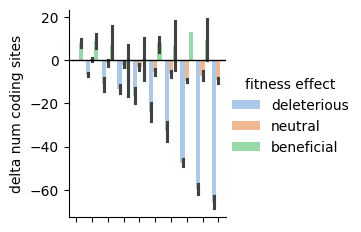

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(6.0), np.float64(11.0))
(np.float64(6.0), np.float64(8.75))
(np.float64(7.0), np.float64(7.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(-1.0), np.float64(2.0))
(np.float64(0.0), np.float64(1.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(21.0))
(np.float64(4.0), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-23.0), np.float64(2.0))
(np.float64(-16.75), np.float64(-7.0))
(np.float64(-11.5), np.float64(-11.5))
(np.float64(-5.0), np.float64(3.0))
(np.float64(-2.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(9.0))
(np.float64(-0.5), np.float64(8.5))
(np.float64(4.0), np.float64(4.0))
(np.float64(-31.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.0))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-9.0), np

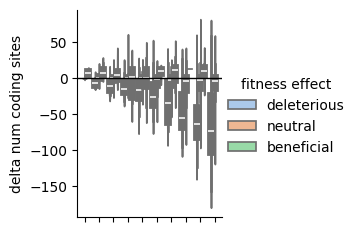

(np.float64(0.028795811518324606), np.float64(0.12827225130890052))
(np.float64(6.0), np.float64(9.75))
(np.float64(-7.314244186046511), np.float64(-5.860174418604651))
(np.float64(-0.24199346405228758), np.float64(1.2222222222222223))
(np.float64(5.844230769230769), np.float64(12.155769230769229))
(np.float64(-14.076923076923077), np.float64(-8.190384615384616))
(np.float64(-2.7195121951219514), np.float64(-0.2073170731707317))
(np.float64(0.6666666666666666), np.float64(15.0))
(np.float64(-15.395348837209303), np.float64(-11.371802325581395))
(np.float64(-3.2516467065868264), np.float64(-0.898053892215569))
(np.float64(-17.0), np.float64(7.2277777777777725))
(np.float64(-19.96512345679012), np.float64(-13.123148148148148))
(np.float64(-4.36670792079208), np.float64(-1.8564356435643565))
(np.float64(-8.357142857142858), np.float64(10.142857142857142))
(np.float64(-28.684931506849313), np.float64(-19.64246575342466))
(np.float64(-7.098765432098766), np.float64(-4.023456790123458))
(np.

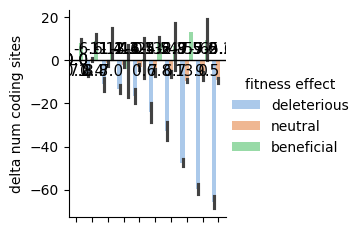

(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(6.0), np.float64(11.0))
(np.float64(6.0), np.float64(8.75))
(np.float64(7.0), np.float64(7.0))
(np.float64(-13.0), np.float64(0.0))
(np.float64(-9.0), np.float64(-5.0))
(np.float64(-7.0), np.float64(-7.0))
(np.float64(-1.0), np.float64(2.0))
(np.float64(0.0), np.float64(1.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(3.0), np.float64(21.0))
(np.float64(4.0), np.float64(12.0))
(np.float64(7.0), np.float64(7.0))
(np.float64(-23.0), np.float64(2.0))
(np.float64(-16.75), np.float64(-7.0))
(np.float64(-11.5), np.float64(-11.5))
(np.float64(-5.0), np.float64(3.0))
(np.float64(-2.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-1.0), np.float64(9.0))
(np.float64(-0.5), np.float64(8.5))
(np.float64(4.0), np.float64(4.0))
(np.float64(-31.0), np.float64(7.0))
(np.float64(-19.0), np.float64(-6.0))
(np.float64(-15.5), np.float64(-15.5))
(np.float64(-9.0), np

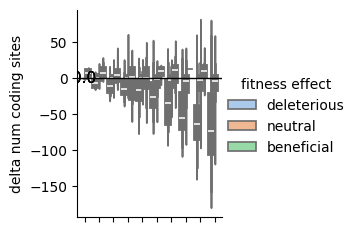

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=num-tasks-has+ext=.pdf
teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=probability+viz=displot+x=num-tasks-has+ext=.png


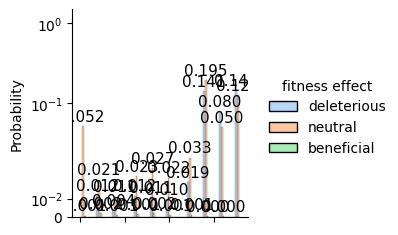

teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=num-tasks-has+ext=.pdf


teeplots/col=what+hue=fitness-effect+kind=hist+multiple=dodge+palette=pastel+stat=count+viz=displot+x=num-tasks-has+ext=.png


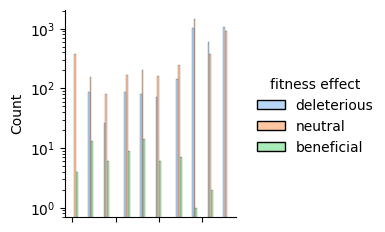

In [35]:
for x in "fitness effect", "max components", "num tasks has":
    for kind in "bar", "violin":
        saveit, g = tp.tee(
            sns.catplot,
            data=dfz.to_pandas(),
            col="what",
            x=x,
            y="delta num coding sites",
            hue="fitness effect",
            hue_order=["deleterious", "neutral", "beneficial"],
            kind=kind,
            palette="pastel",
            teeplot_callback=True,
            aspect=0.9,
            height=3,
        )
        if x != "max components":
            g.set(xticklabels=[], xlabel="")
        else:
            g.set(xlabel="max task complexity")
        g.set_titles("")
        for ax in g.axes.flat:
            xs = [line.get_xdata().min() for line in ax.lines]
            lower = [line.get_ydata().min() for line in ax.lines]
            upper = [line.get_ydata().max() for line in ax.lines]
            cis = [*zip(lower, upper)]
            order = np.argsort(xs)
            for o in order:
                print(cis[o])
            ax.axhline(0, color="black", linewidth=1)
        saveit()

    for kind in "bar", "violin":
        saveit, g = tp.tee(
            sns.catplot,
            data=dfz.to_pandas(),
            col="what",
            x=x,
            y="delta num coding sites",
            hue="fitness effect",
            hue_order=["deleterious", "neutral", "beneficial"],
            kind=kind,
            palette="pastel",
            teeplot_callback=True,
            teeplot_outattrs={"textlabels": True},
            aspect=0.9,
            height=3,
        )
        if x != "max components":
            g.set(xticklabels=[], xlabel="")
        else:
            g.set(xlabel="max task complexity")
        g.set_titles("")
        for ax in g.axes.flat:
            xs = [line.get_xdata().min() for line in ax.lines]
            lower = [line.get_ydata().min() for line in ax.lines]
            upper = [line.get_ydata().max() for line in ax.lines]
            cis = [*zip(lower, upper)]
            order = np.argsort(xs)
            for o in order:
                print(cis[o])
            ax.axhline(0, color="black", linewidth=1)
            # add count labels
            # adapted from https://stackoverflow.com/a/55319634/17332200
            for p in ax.patches:
                ax.annotate(
                    text=f"{p.get_height():1.1f}",
                    xy=(
                        p.get_x() + p.get_width() / 2.,
                        -5 * np.sign(p.get_height())
                    ),
                    xycoords="data",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="black",
                    xytext=(0,0),
                    textcoords="offset points",
                    clip_on=True,                   # <---  important
                )
        saveit()

    saveit, g = tp.tee(
        sns.displot,
        data=dfz.to_pandas(),
        col="what",
        x=x,
        kind="hist",
        hue="fitness effect",
        hue_order=["deleterious", "neutral", "beneficial"],
        multiple="stack" if x == "fitness effect" else "dodge",
        palette="pastel",
        stat="probability",
        teeplot_callback=True,
        aspect=0.9,
        height=3,
    )
    plt.yscale("symlog", linthresh=5e-2)
    g.set(xticklabels=[], xlabel="", ylim=(0, 1.5))
    g.set_titles("")

    # add count labels
    # adapted from https://stackoverflow.com/a/55319634/17332200
    for ax in g.axes.flat:
        xs = [line.get_xdata().min() for line in ax.lines]
        lower = [line.get_ydata().min() for line in ax.lines]
        upper = [line.get_ydata().max() for line in ax.lines]
        cis = [*zip(lower, upper)]
        order = np.argsort(xs)
        for o in order:
            print(cis[o])

        for p in ax.patches:
            if p.get_height() > 0.0001:
                ax.annotate(
                    text=f"{p.get_height():1.3f}",
                    xy=(
                        p.get_x() + p.get_width() / 2.,
                        p.get_height(),
                    ),
                    xycoords="data",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="black",
                    xytext=(0,7),
                    textcoords="offset points",
                    clip_on=True,                   # <---  important
                )

    saveit()

    saveit, g = tp.tee(
        sns.displot,
        data=dfz.to_pandas(),
        col="what",
        x=x,
        kind="hist",
        hue="fitness effect",
        hue_order=["deleterious", "neutral", "beneficial"],
        stat="count",
        palette="pastel",
        multiple="stack" if x == "fitness effect" else "dodge",
        teeplot_callback=True,
        aspect=0.9,
        height=3,
    )
    plt.yscale("log")
    if x != "max components":
        g.set(xticklabels=[], xlabel="")
    else:
        g.set(xlabel="max task complexity")
    g.set_titles("")

    # add count labels
    # adapted from https://stackoverflow.com/a/55319634/17332200
    for ax in g.axes.flat:
        xs = [line.get_xdata().min() for line in ax.lines]
        lower = [line.get_ydata().min() for line in ax.lines]
        upper = [line.get_ydata().max() for line in ax.lines]
        cis = [*zip(lower, upper)]
        order = np.argsort(xs)
        for o in order:
            print(cis[o])

        for p in ax.patches:
            ax.annotate(
                text=f"{p.get_height():1.0f}",
                xy=(
                    p.get_x() + p.get_width() / 2.,
                    -5 * np.sign(p.get_height()),
                ),
                xycoords="data",
                ha="center",
                va="center",
                fontsize=11,
                color="black",
                xytext=(0,0),
                textcoords="offset points",
                clip_on=True,                   # <---  important
            )

    saveit()


In [36]:
for x in "fitness effect", "max components", "num tasks has":
    display(
        dfz.to_pandas().groupby(
            ["what", x, "fitness effect"],
        ).agg(
            {
                "delta frac coding sites": ["median", "mean", "std", "count"],
            },
        ),
    )


delta frac coding sites            \
                                                         median      mean   
what      fitness effect fitness effect                                     
insertion beneficial     beneficial                    0.300000       inf   
          deleterious    deleterious                  -0.943741 -0.677902   
          neutral        neutral                      -0.030928       inf   

                                                         
                                              std count  
what      fitness effect fitness effect                  
insertion beneficial     beneficial           NaN    62  
          deleterious    deleterious     0.395289  3202  
          neutral        neutral              NaN  3782

delta frac coding sites            \
                                                         median      mean   
what      max components fitness effect                                     
insertion 0              neutral                       1.000000       inf   
          1              beneficial                    2.400000       inf   
                         deleterious                  -0.692308 -0.623165   
                         neutral                       0.000000  0.051175   
          2              beneficial                    0.600000  2.063411   
                         deleterious                  -0.812500 -0.626390   
                         neutral                       0.000000 -0.115255   
          3              beneficial                    0.102941  0.062434   
                         deleterious                  -0.601171 -0.491575   
                         neutral                      -0.020870 -0.102038   
          4              beneficial                    0.222222  0.293770   
                         deleterious                  -0.946429 -0.714866   
                         neutral                      -0.054545 -0.140572   
          5              beneficial                    0.101064  0.101064   
                         deleterious                  -0.950000 -0.669951   
                         neutral                      -0.033333 -0.094742   

                                                         
                                              std count  
what      max components fitness effect                  
insertion 0              neutral              NaN    34  
          1              beneficial           NaN     9  
                         deleterious     0.380656   101  
                         neutral         0.561517   173  
          2              beneficial      3.902785    11  
                         deleterious     0.405080    97  
                         neutral         0.426855   227  
          3              beneficial      0.419986    23  
                         deleterious     0.505809   178  
                         neutral         0.300432   430  
          4              beneficial      0.628640    17  
                         deleterious     0.377912  1473  
                         neutral         0.233209  1830  
          5              beneficial      0.142926     2  
                         deleterious     0.389940  1353  
                         neutral         0.206517  1088

delta frac coding sites            \
                                                        median      mean   
what      num tasks has fitness effect                                     
insertion 0             beneficial                         inf       inf   
                        neutral                       1.000000       inf   
          1             beneficial                    1.000000  1.262510   
                        deleterious                  -0.692308 -0.652749   
                        neutral                       0.000000  0.045828   
          2             beneficial                    0.162963  2.358699   
                        deleterious                  -0.741667 -0.577949   
                        neutral                       0.000000 -0.077346   
          3             beneficial                    0.095238  0.031198   
                        deleterious                  -0.823529 -0.593874   
                        neutral                       0.000000 -0.063887   
          4             beneficial                   -0.014685  0.064237   
                        deleterious                  -0.625000 -0.508391   
                        neutral                       0.000000 -0.086759   
          5             beneficial                    0.358876  0.263134   
                        deleterious                  -0.896552 -0.564200   
                        neutral                      -0.022497 -0.129672   
          6             beneficial                    0.222222  0.148368   
                        deleterious                  -0.903226 -0.571140   
                        neutral                      -0.046512 -0.135508   
          7             beneficial                    0.254902  0.254902   
                        deleterious                  -0.949153 -0.724539   
                        neutral                      -0.064516 -0.148390   
          8             beneficial                    0.101064  0.101064   
                        deleterious                  -0.947368 -0.759841   
                        neutral                      -0.019802 -0.078622   
          9             deleterious                  -0.953596 -0.633167   
                        neutral                      -0.037975 -0.103640   

                                                        
                                             std count  
what      num tasks has fitness effect                  
insertion 0             beneficial           NaN     4  
                        neutral              NaN    34  
          1             beneficial      0.915742    13  
                        deleterious     0.360009    85  
                        neutral         0.586070   148  
          2             beneficial      5.461317     6  
                        deleterious     0.395109    26  
                        neutral         0.342736    82  
          3             beneficial      0.591633     9  
                        deleterious     0.429795    85  
                        neutral         0.495837   165  
          4             beneficial      0.406248    14  
                        deleterious     0.476752    81  
                        neutral         0.302970   202  
          5             beneficial      0.197995     6  
                        deleterious     0.512730    73  
                        neutral         0.259962   162  
          6             beneficial      0.310998     7  
                        deleterious     0.444571   143  
                        neutral         0.250449   245  
          7             beneficial           NaN     1  
                        deleterious     0.376167  1041  
                        neutral         0.231369  1443  
          8             beneficial      0.142926     2  
                        deleterious     0.335634   594  
                        neutral         0.232979   371  
          9             delet

teeplots/col=num-tasks-has+kind=hist+row=what+viz=displot+x=delta-num-coding-sites+y=delta-num-tasks-has+ext=.pdf


teeplots/col=num-tasks-has+kind=hist+row=what+viz=displot+x=delta-num-coding-sites+y=delta-num-tasks-has+ext=.png


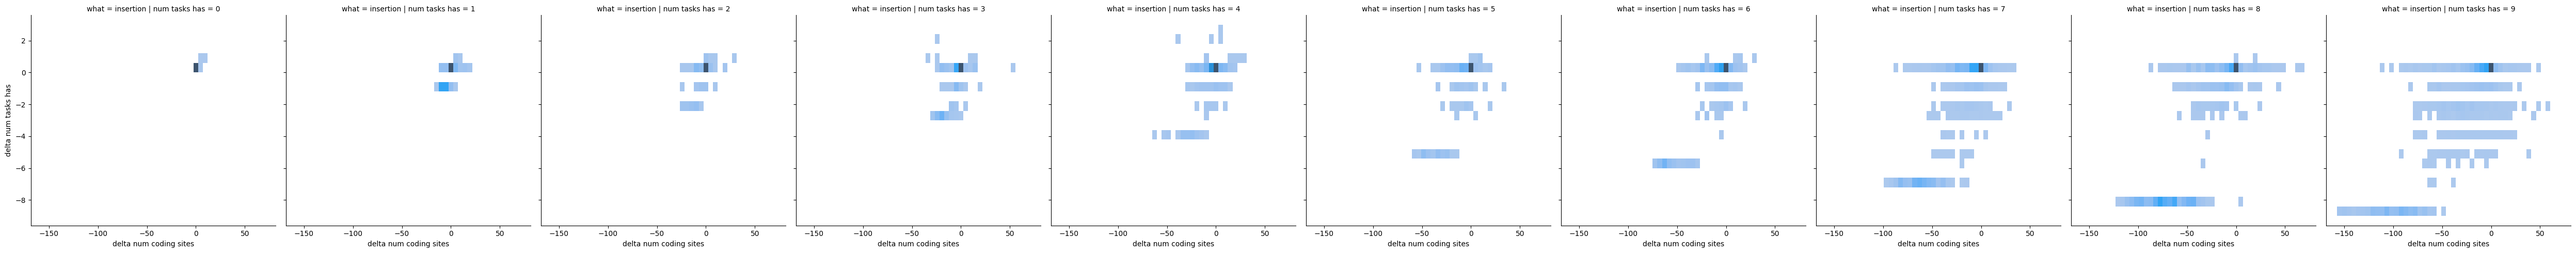

In [37]:
tp.tee(
    sns.displot,
    data=dfz.to_pandas(),
    x="delta num coding sites",
    y="delta num tasks has",
    row="what",
    common_norm=False,
    col="num tasks has",
    kind="hist",
)
